# 2 Microscopic Traffic Simulation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import traci
import time
import xml.etree.ElementTree as ET
import pandas as pd

## 2.1 Model building and generate random vehicle input  


First, we need to generate random vehicle arrival that follows the poisson process. In this case, the arrival times are directly representing the time that the vehicle is loaded on the road. We assume that the arrival rate of vehicles is 3000/3600, meaning that there will be 3000 vehicles loading on the road in one hour. 
<!-- And we use the method that mentioned in th Sheldon M. Ross's simulation book to decide when to stop generate new vehicle. -->

[0.10821387257174435, 0.9662414661739811, 4.119161153842984, 0.0014983950532741672, 0.9654826809658135, 2.4309077842574967, 0.009627541452674492, 0.3809649351828929, 0.6843640916999971, 0.3471601358633993, 0.10471508194429595, 1.1145583844732971, 0.15363144940142656, 1.1209816392688623, 0.605124062077656, 0.8587446584688412, 0.10476403176200635, 2.5198219015595806, 0.8255604501914423, 1.8075422272168065, 0.1979108054549516, 0.09953857576650768, 1.052474406276795, 0.11114253379692346, 2.213441819371873, 1.252080227880292, 0.1123998257674604, 3.6922754328182372, 3.6401364809673016, 1.1173411227792276, 0.8741985517350007, 1.4889028263514466, 0.1042193307639554, 5.792431271206689, 0.5735648536162068, 0.19465452150324639, 2.735225794043874, 0.044808505971564626, 0.173232121636398, 2.872144857586577, 2.430794920604191, 0.27402737136977884, 0.43260167390034876, 0.18399743544754832, 1.4375373241697826, 1.5015836998263694, 0.05821493134093629, 1.9898908900887322, 1.4438682148552309, 1.396270684

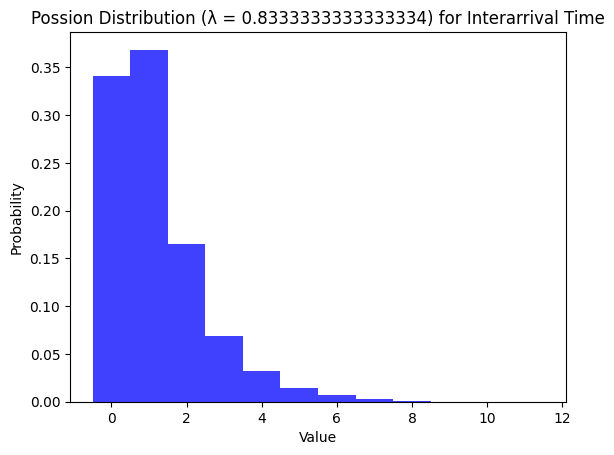

In [381]:
def generate_interarrival_time(lamda):
  start_time=0
  t = start_time

  u1 = np.random.random()
  t -= np.log(u1) / lamda
  
  return t

arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour


# Plot the histogram of multiple generated arrival time random variables
random_variable_size = 10000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

print(interarrival_times)

# Plot the histogram of generated arrival time random variables
plt.hist(interarrival_times, bins=np.arange(min(interarrival_times), max(interarrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title(f'Possion Distribution (λ = {arrival_rate}) for Interarrival Time')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called AH2174_2023_project1_section2.rou.xml. All these vehicles will go through from edge 1 to edge 5. We assume there are two types of vehicle. One is 'Car', its acceleration is 2.5 m/s2, its deceleration is 5m/s2, and its vehicle legnth is 5 meters. Another one is 'Bus', its accelaration is 1.5 m/s2, its deceleration is 4 m/s2, and it vehicle length is 18 meters. Both of them have IDM car follow model.

And we assign the vehicle type randomly to each vehicle. But considering that normally there will be more cars on the road, so we assume a vehicle 70 percent probability to be a car. 

To ensure that the 70km/h speed limit of the road working, we set the maximum speed of vehicle type as 19.44m/s and also the maximum speed of the edge to 19.44.

In [412]:
def vehicle2file(interarrival_times):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open('AH2174_2023_project1_section2.rou.xml', 'w') as f:
        f.write('<routes>\n')
        f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="19.44" sigma="0.0" carFollowModel="IDM"/>\n')
        f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="19.44" sigma="0.0" carFollowModel="IDM" />\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        depart_time=0 
        inital_speed=5
        max_speed=19.44
        for num_vehicles,time in enumerate(interarrival_times):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            depart_time+=time

            vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]

            # if num_vehicles<(len(interarrival_times)-1):
            #     if vehicle_type=='Car':
            #         inital_speed=min(5/interarrival_times[num_vehicles+1],max_speed)
            #     else:
            #         inital_speed=min(18/interarrival_times[num_vehicles+1],max_speed)
            # else:
            #     inital_speed=0

            f.write(f'<vehicle depart="{depart_time}" route="r1" id="{num_vehicles}" type="{vehicle_type}" departSpeed="{inital_speed}" departLane="free"/>\n')
        f.write('</routes>')

To check the number of vehicles loaded on the specific highway section in a SUMO simulation, we can use the traci module, which is the interface for interacting with a running SUMO simulation.  We need to query the vehicles that are currently present on the edges representing the highway section of interest.

In [413]:
 # generate the arrival time that follows the poisson process
arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

# generate the new rou.xml
vehicle2file(interarrival_times)

In [394]:
traci.close()

In [414]:
# Start the SUMO simulation with your configuration file (e.g., sumo_test.sumocfg)
traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg", "--route-steps","0"])

# Run the simulation for a certain number of steps
i=1
simulation_steps = 3600
warmup_steps = 300  # 适度增加 warm-up 步数

# Define the edges representing the highway section (e.g., edge1, edge2, etc.)
highway_edges = ["edge1", "edge2", "edge3", "edge4", "edge5"]
for _ in range(simulation_steps+warmup_steps):
    traci.simulationStep()
    IDList = traci.vehicle.getIDList()
    # print the vehicle info when not empty
    if len(IDList):
        # Get the list of currently loaded vehicles on the highway section
        loaded_vehicles_on_highway = [v for v in IDList if traci.vehicle.getRoadID(v) in highway_edges]
        # Get the number of loaded vehicles on the highway section
        num_loaded_vehicles_on_highway = len(loaded_vehicles_on_highway)  
        print(i, IDList)
        print(f'Number of loaded vehicles on the highway section: {num_loaded_vehicles_on_highway}')
    i=i+1

traci.close()
print("SUMO simulation finished!")


2 ('0',)
Number of loaded vehicles on the highway section: 1
3 ('0',)
Number of loaded vehicles on the highway section: 1
4 ('0', '1')
Number of loaded vehicles on the highway section: 2
5 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
6 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
7 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
8 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
9 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
10 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
11 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
12 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
13 ('0', '1', '2', '3', '4')
Number of loaded vehicles on the highway section: 5
14 ('0', '1', '2', '3', '4', '5')
Number of loaded vehicles on the highway section: 6
15 ('0', '1', '2', '3', '4', '5')
Number of loaded vehicles on the highwa

## 2.2 Simulation output

In this task, we use the trajectory data to estimate the average traffic speed in the highway segments (from edge2 to edge 5), as aggregated for 5 minutes interval.

In [ ]:
pd.set_option('display.max_columns', None)

In [444]:
def parse_vehilce_data(warmup_steps,xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Extract vehicle trajectory information
    data_time= {}
    data_pos={}

    for timestep in root.findall(".//timestep"):
        time = float(timestep.get('time'))
        if time > warmup_steps:
            for edge in timestep.findall('.//edge'):
                edge_id = edge.get('id')
                if edge_id != 'edge1':
                    for edge_lane in timestep.findall(f'.//edge[@id="{edge_id}"]'):
                        for vehicle in edge_lane.findall('.//vehicle'):
                            vehicle_id = vehicle.get('id')
                            position = float(vehicle.get('pos'))                    
                            if vehicle_id not in data_time:
                                data_time[vehicle_id]=[]
                            if vehicle_id not in data_pos:
                                data_pos[vehicle_id]=[]
                            
                            data_time[vehicle_id].append(time)
                            data_pos[vehicle_id].append(position)

    # Convert dictionary to DataFrame
    df_t = pd.DataFrame.from_dict(data_time, orient='index')
    df_p = pd.DataFrame.from_dict(data_pos, orient='index')
    return df_t,df_p

In [449]:
def calculate_average_traffic_speed(warmup_steps,df_t,df_p):
  average_traffic_speed={}

  time_interval_values = [x for x in range(warmup_steps, warmup_steps+3601, 300)]
  time_interval_values

  for i in time_interval_values:
    if i == warmup_steps+3600:
      break

    # Filter rows where any column in df_t is greater than 0 and less than 300
    mask = (df_t.ge(i) & df_t.le(i+300)).any(axis=1)

    # Apply the mask to df_t and df_p
    filtered_df_t = df_t[mask]
    filtered_df_p = df_p[mask]

    # Calculate the total time for each vehicle
    travel_time= filtered_df_t.apply(lambda row: row.max() - row.min(), axis=1).replace(0, pd.NA).dropna()
    travel_distance_changes= filtered_df_p.diff(axis=1)
    travel_distance=travel_distance_changes[travel_distance_changes>0].sum(axis=1)

    # Convert position to speed (assuming it's in meters and time is in seconds)
    speeds=travel_distance / travel_time

    average_traffic_speed[i]=(np.mean(speeds))
  return average_traffic_speed

In [460]:
# Run the simulation for a certain number of steps
simulation_steps = 3600  
warmup_steps = 300

# Number of simulation runs
num_simulations = 5

# Store the results of each simulation
all_simulation_results = []

# Specify the network file based on the scenario you want to run
# network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_section2.sumo.cfg'


# Run multiple simulations with different random seeds
for run in range(num_simulations):
    # Choose a different random seed for each run
    random_seed = np.random.randint(1, 1000)
    # print(random_seed)    

    # generate the arrival time that follows the poisson process
    arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
    random_variable_size = 3000
    interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

    # generate the new rou.xml
    vehicle2file(interarrival_times)

    # Start the SUMO simulation with your configuration file
    traci.start(["sumo", "-c", configuration_file])

    for step in range(simulation_steps + warmup_steps):
      traci.simulationStep()
    
    traci.close()

    df_t,df_p=parse_vehilce_data(warmup_steps,'AH2174_2023_project1_section2_Vehicle_data_1.xml')
    all_simulation_results.append(calculate_average_traffic_speed(warmup_steps,df_t,df_p))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


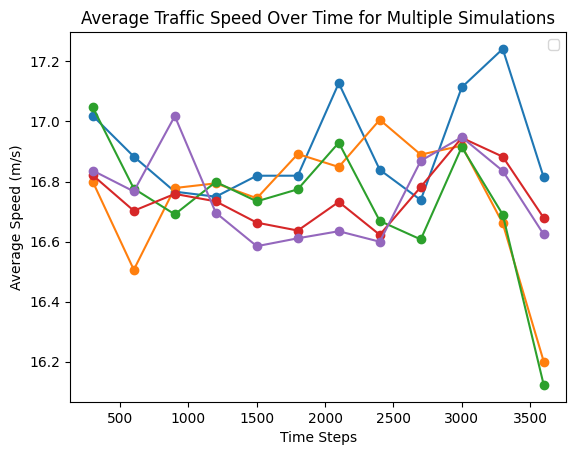

In [461]:
# Plot the results for each simulation run
for i, simulation_results in enumerate(all_simulation_results):
    time_intervals = list(simulation_results.keys())
    average_speed_values = list(simulation_results.values())

    plt.plot(time_intervals, average_speed_values, marker='o', linestyle='-')

plt.title('Average Traffic Speed Over Time for Multiple Simulations')
plt.xlabel('Time Steps')
plt.ylabel('Average Speed (m/s)')
plt.legend()
plt.show()

As the results showen ont the plot, there are some variability and disperson in the results for each simulation run. And there are may be some factors that contribute to this kind of randomness:

1. Stochasticity in vehicle arrivals: Our vehicle arrivals follow a stochastic process. And we generate new random vehicle arrival times to initialize each simulation. It can introduce variability in traffic patterns. 

2. Randomness in driver behavior: We defined the car following model as IDM, leading to various driver behaviors. Different drivers with new gennerated vehicle parameters may exhibit varying behaviors in different simulation runs , affecting traffic flow.

## 2.3 Alternative scenario

To simulate the new scenario, we generate a new add.file (AH2174_2023_project1_Section2_alternativescenario.add.xml). In this new add.xml, the closure begin time of the two rightomost lanes is set to 2100, and the end time is set to 3300, considering that the warmup period is 300 seconds. And the speed limit during the lane closure is set to 30 km/h. 

netconvert --node-files AH2174_2023_project1_Section2.nod.xml --edge-files AH2174_2023_project1_Section2_alternativescenario.edge.xml -t AH2174_2023_project1_Section2.type.xml -o AH2174_2023_project1_Section2_alternativescenario.net.xml

Run Simulations:   
Run simulations for both the original and alternative scenarios. Each one with 10 simulation runs.

Collect Data:   
Extract relevant data from simulation outputs, including average speeds.

Statistical Evaluation:  
1. Calculate and compare the changes of average traffic speeds on edge 3&4&5 for both scenarios. Average Traffic Speeds represent the average speed of vehicles on edge over a given period. Its changes can indicate traffic congestion, revealing the efficency and flow of vehicles.
2. Hypothesis testing (t-test) on edge 4 to prove that the lane closure does effect the traffic speed

Plots:
Create plots to visually compare average speeds of the two scenarios over time.

In [447]:
# Function to parse the XML file and extract trajectory data
def parse_vehilce_data_2(warmup_steps,xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Extract vehicle trajectory information
    data_time_e3= {}
    data_pos_e3={}
    data_time_e4= {}
    data_pos_e4={}
    data_time_e5= {}
    data_pos_e5={}

    for timestep in root.findall(".//timestep"):
        time = float(timestep.get('time'))
        if time > warmup_steps:
            for edge in timestep.findall('.//edge'):
                edge_id = edge.get('id')
                if edge_id == 'edge3':
                    for edge_lane in timestep.findall(f'.//edge[@id="{edge_id}"]'):
                        for vehicle in edge_lane.findall('.//vehicle'):
                            vehicle_id = vehicle.get('id')
                            position = float(vehicle.get('pos'))                    
                            if vehicle_id not in data_time_e3:
                                data_time_e3[vehicle_id]=[]
                            if vehicle_id not in data_pos_e3:
                                data_pos_e3[vehicle_id]=[]
                            
                            data_time_e3[vehicle_id].append(time)
                            data_pos_e3[vehicle_id].append(position)

                elif edge_id == 'edge4':
                    for edge_lane in timestep.findall(f'.//edge[@id="{edge_id}"]'):
                        for vehicle in edge_lane.findall('.//vehicle'):
                            vehicle_id = vehicle.get('id')
                            position = float(vehicle.get('pos'))                    
                            if vehicle_id not in data_time_e4:
                                data_time_e4[vehicle_id]=[]
                            if vehicle_id not in data_pos_e4:
                                data_pos_e4[vehicle_id]=[]
                            
                            data_time_e4[vehicle_id].append(time)
                            data_pos_e4[vehicle_id].append(position)
                
                elif edge_id=='edge5':
                    for edge_lane in timestep.findall(f'.//edge[@id="{edge_id}"]'):
                        for vehicle in edge_lane.findall('.//vehicle'):
                            vehicle_id = vehicle.get('id')
                            position = float(vehicle.get('pos'))                    
                            if vehicle_id not in data_time_e5:
                                data_time_e5[vehicle_id]=[]
                            if vehicle_id not in data_pos_e5:
                                data_pos_e5[vehicle_id]=[]
                            
                            data_time_e5[vehicle_id].append(time)
                            data_pos_e5[vehicle_id].append(position)

    # Convert dictionary to DataFrame
    df_t_e3 = pd.DataFrame.from_dict(data_time_e3, orient='index')
    df_p_e3 = pd.DataFrame.from_dict(data_pos_e3, orient='index')
    df_t_e4 = pd.DataFrame.from_dict(data_time_e4, orient='index')
    df_p_e4 = pd.DataFrame.from_dict(data_pos_e4, orient='index')
    df_t_e5 = pd.DataFrame.from_dict(data_time_e5, orient='index')
    df_p_e5 = pd.DataFrame.from_dict(data_pos_e5, orient='index')

    return df_t_e3,df_p_e3,df_t_e4,df_p_e4,df_t_e5,df_p_e5

In [466]:
import pandas as pd
def simulation_scenario(network_file, configuration_file,xml_data_path):
    # Run the simulation for a certain number of steps
    simulation_steps = 3600  
    warmup_steps = 300

    # Store the results of each simulation for edge4
    all_simulation_results_edge3 = []
    all_simulation_results_edge4 = []
    all_simulation_results_edge5 = []

    edge_length = 1000  # Adjust the length according to your network
    

    # Number of simulation runs
    num_simulations = 10

    # Run multiple simulations with different random seeds
    for run in range(num_simulations):
        # Choose a different random seed for each run
        # random_seed = np.random.randint(1, 1000)
        # print(random_seed)    

        # generate the arrival time that follows the poisson process
        arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
        random_variable_size = 3000
        interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

        # generate the new rou.xml
        vehicle2file(interarrival_times)

        # Start the SUMO simulation with your configuration file
        traci.start(["sumo", "-c", configuration_file])

        for step in range(simulation_steps + warmup_steps):
            traci.simulationStep()
        
        traci.close()
                
        # Parse the XML file to get average speeds (excluding warmup)
        df_t_e3,df_p_e3,df_t_e4,df_p_e4,df_t_e5,df_p_e5=parse_vehilce_data_2(warmup_steps,xml_data_path)

        all_simulation_results_edge3.append(calculate_average_traffic_speed(warmup_steps,df_t_e3,df_p_e3))
        all_simulation_results_edge4.append(calculate_average_traffic_speed(warmup_steps,df_t_e4,df_p_e4))
        all_simulation_results_edge5.append(calculate_average_traffic_speed(warmup_steps,df_t_e5,df_p_e5))

    return all_simulation_results_edge4,all_simulation_results_edge3,all_simulation_results_edge5

In [458]:
def plot_simulation_results(edgeid, all_simulation_results):
    # Plot the results for each simulation run for edge4
    for i, simulation_results in enumerate(all_simulation_results):
        time_intervals = list(simulation_results.keys())
        average_speed_values = list(simulation_results.values())

        plt.plot(time_intervals, average_speed_values, marker='o', linestyle='-', label=f'Simulation {i + 1}')

    plt.title(f'Average Traffic Speed on {edgeid} Over Time for Multiple Simulations')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.show()

In [462]:
def print_simulation_average_results(edgeid,all_simulation_results):
    
    time_intervals = list(all_simulation_results[0].keys())

    # Initialize dictionaries to store the sum of values for each time period
    sum_speeds = {time: 0 for time in time_intervals}

    # Calculate the sum of values for each time period
    for simulation_results in all_simulation_results:
        for time, speed in simulation_results.items():
            sum_speeds[time] += speed
        
        # for time, density in simulation_results_edge4['traffic_density'].items():
        #     sum_traffic_density[time] += density

    # Calculate the average values for each time period
    num_simulations = len(all_simulation_results)
    average_speeds = {time: sum_speeds[time] / num_simulations for time in time_intervals}
    # average_traffic_density_edge4 = {time: sum_traffic_density[time] / num_simulations for time in time_intervals_edge4}

    # Create dataframes for average speeds, throughput, and traffic density
    df_speeds = pd.DataFrame(average_speeds.items(), columns=['Time Steps', 'Average Speeds'])
    # df_traffic_density_edge4 = pd.DataFrame(average_traffic_density_edge4.items(), columns=['Time Steps', 'Average Traffic Density'])

    # Merge dataframes on 'Time (seconds)'
    # df_edge4 = pd.merge(df_speeds_edge4, df_traffic_density_edge4, on='Time Steps')

    # Print the table
    print(f"\nAverage Results for {edgeid}:")
    print(df_speeds)

#### original scenario

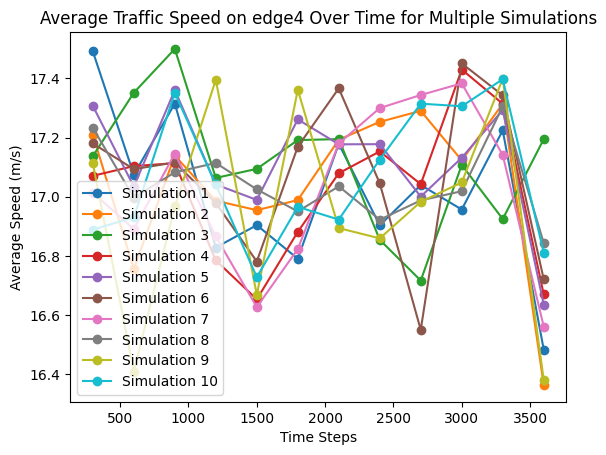

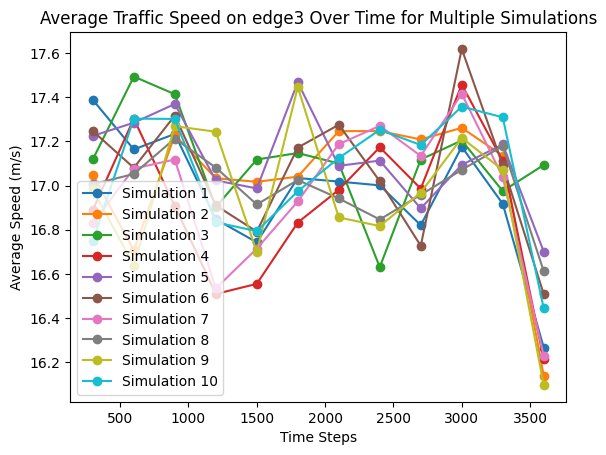

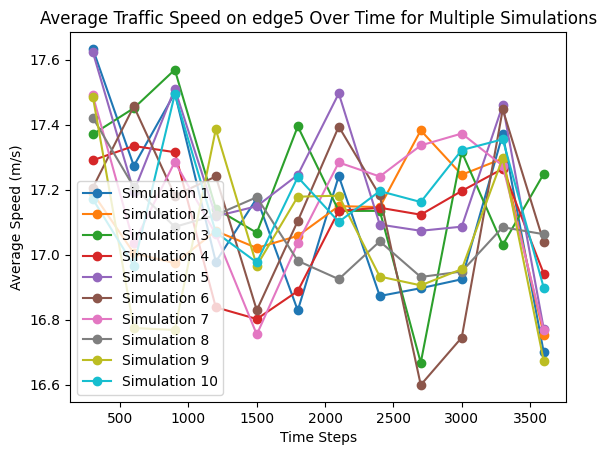


Average Results for edge4:
    Time Steps  Average Speeds
0          300       17.164415
1          600       16.963845
2          900       17.209015
3         1200       17.010003
4         1500       16.842270
5         1800       17.038211
6         2100       17.122077
7         2400       17.059323
8         2700       17.026786
9         3000       17.195534
10        3300       17.265640
11        3600       16.666146

Average Results for edge3:
    Time Steps  Average Speeds
0          300       17.048724
1          600       17.110195
2          900       17.237215
3         1200       16.891905
4         1500       16.833304
5         1800       17.106728
6         2100       17.081919
7         2400       17.037042
8         2700       17.000192
9         3000       17.287111
10        3300       17.101504
11        3600       16.430027

Average Results for edge5:
    Time Steps  Average Speeds
0          300       17.387989
1          600       17.169608
2          900   

In [467]:
# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_section2.sumo.cfg'
xml_file_path = 'AH2174_2023_project1_section2_Vehicle_data_1.xml'

o_all_simulation_results_edge4,o_all_simulation_results_edge3,o_all_simulation_results_edge5=simulation_scenario(network_file, configuration_file,xml_file_path)
plot_simulation_results('edge4', o_all_simulation_results_edge4)
plot_simulation_results('edge3', o_all_simulation_results_edge3)
plot_simulation_results('edge5', o_all_simulation_results_edge5)
print_simulation_average_results('edge4',o_all_simulation_results_edge4)
print_simulation_average_results('edge3',o_all_simulation_results_edge3)
print_simulation_average_results('edge5',o_all_simulation_results_edge5)


#### alternative scenario

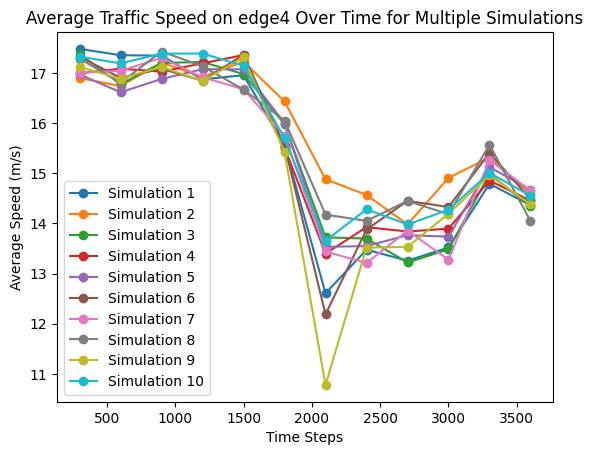

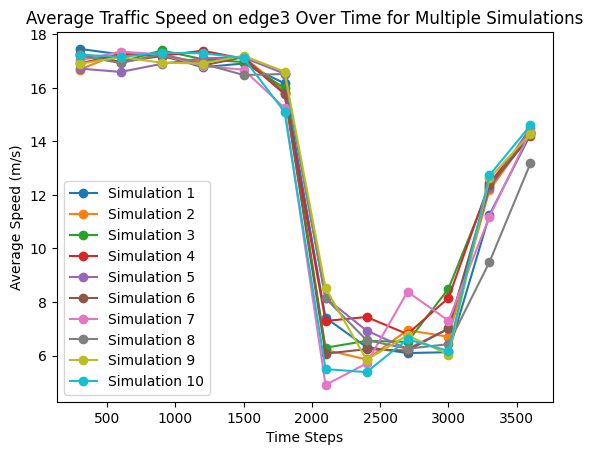

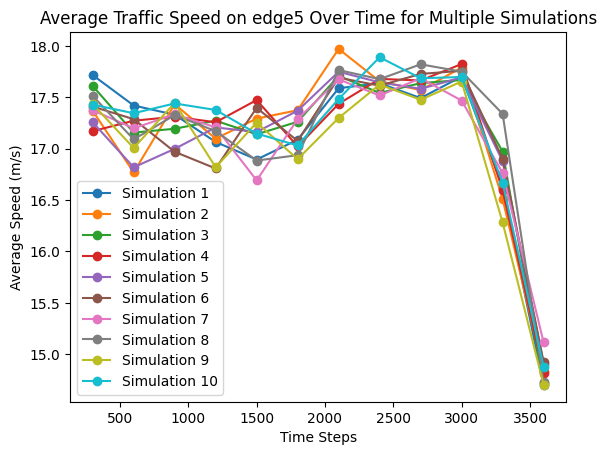


Average Results for edge4:
    Time Steps  Average Speeds
0          300       17.176243
1          600       16.937409
2          900       17.195580
3         1200       17.038139
4         1500       17.073395
5         1800       15.791998
6         2100       13.237879
7         2400       13.814863
8         2700       13.832410
9         3000       13.978723
10        3300       15.126285
11        3600       14.451805

Average Results for edge3:
    Time Steps  Average Speeds
0          300       17.065133
1          600       17.089532
2          900       17.182692
3         1200       17.004868
4         1500       16.985926
5         1800       15.962295
6         2100        6.849139
7         2400        6.283590
8         2700        6.679128
9         3000        6.942495
10        3300       11.881743
11        3600       14.233930

Average Results for edge5:
    Time Steps  Average Speeds
0          300       17.428253
1          600       17.136513
2          900   

In [468]:
# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_Section2_alternativescenario.sumo.cfg'
xml_file_path = 'AH2174_2023_project1_section2_Vehicle_data_2.xml'
a_all_simulation_results_edge4,a_all_simulation_results_edge3,a_all_simulation_results_edge5=simulation_scenario(network_file, configuration_file,xml_file_path)
plot_simulation_results('edge4', a_all_simulation_results_edge4)
plot_simulation_results('edge3', a_all_simulation_results_edge3)
plot_simulation_results('edge5', a_all_simulation_results_edge5)
print_simulation_average_results('edge4',a_all_simulation_results_edge4)
print_simulation_average_results('edge3',a_all_simulation_results_edge3)
print_simulation_average_results('edge5',a_all_simulation_results_edge5)

We use hypothesis testing (t-test) to the average speed of edge 3&4&5 in these two scenarios.   
Null hypothesis: there is no significant difference in average speeds between the original and alternative scenario  
Alternative hypothesis: there is a significant difference in average speeds between the original and alternative scenario.


In [478]:
def calculate_average_speeds_over_multiple_runs(all_simulation_results):
    # Initialize a dictionary to store average speeds for each time step
    average_speeds_dict = {}

    # Extract speeds for each simulation run
    for simulation_results in all_simulation_results:
        average_speeds = simulation_results

        # Update the dictionary with speeds for each time step
        for time, speed in average_speeds.items():
            if time not in average_speeds_dict:
                average_speeds_dict[time] = []
            average_speeds_dict[time].append(speed)

    # Calculate the mean average speed for each time step
    for time, speeds_list in average_speeds_dict.items():
        average_speeds_dict[time] = sum(speeds_list) / len(speeds_list)

    return average_speeds_dict

In [475]:
import scipy.stats as stats

def t_test_average_speeds(o_all_simulation_results, a_all_simulation_results):
    # Calculate average speeds for each time step for both scenarios
    average_speeds_dict_scenario1 = calculate_average_speeds_over_multiple_runs(o_all_simulation_results)
    average_speeds_dict_scenario2 = calculate_average_speeds_over_multiple_runs(a_all_simulation_results)

    # Extract speeds for all simulation runs
    speeds_scenario1 = list(average_speeds_dict_scenario1.values())
    speeds_scenario2 = list(average_speeds_dict_scenario2.values())

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(speeds_scenario1, speeds_scenario2)

    return t_stat, p_value

In [476]:
def ttest_result(o_all_simulation_results, a_all_simulation_results):
    # Example usage
    scenario1 = 'original'
    scenario2 = 'alternative'
    t_stat, p_value = t_test_average_speeds(o_all_simulation_results, a_all_simulation_results)

    # Print results
    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_value}')

    # Determine significance level (e.g., 0.05)
    alpha = 0.05

    # Check if the p-value is less than the significance level
    if p_value < alpha:
        print('The difference in average speeds between scenarios is statistically significant.')
    else:
        print('There is no statistically significant difference in average speeds between scenarios.')

In [479]:
print('t-test for edge3:')
ttest_result(o_all_simulation_results_edge3, a_all_simulation_results_edge3)
print('t-test for edge4:')
ttest_result(o_all_simulation_results_edge4, a_all_simulation_results_edge4)
print('t-test for edge5:')
ttest_result(o_all_simulation_results_edge5, a_all_simulation_results_edge5)

t-test for edge3:
T-statistic: 3.0036120026649
P-value: 0.0065396389050536245
The difference in average speeds between scenarios is statistically significant.
t-test for edge4:
T-statistic: 3.466769459918863
P-value: 0.0021919266018857633
The difference in average speeds between scenarios is statistically significant.
t-test for edge5:
T-statistic: 0.059303023581449434
P-value: 0.9532461501369247
There is no statistically significant difference in average speeds between scenarios.
